In [109]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys

main_dir = os.path.dirname(os.path.abspath('../'))
sys.path.insert(0, main_dir)

from forward.fourier import method, kernel_creator
from models.helper import create_bs_data

GPU_ID = 1
if torch.cuda.is_available():
    torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")

%load_ext autoreload
%autoreload 2

5 GPU(s) available:
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Can we test the fourier kernel?

In [110]:
kernel = kernel_creator.create_fourier_kernel().unsqueeze(0).permute(0,3,1,2);
# cube, dispersed_mask, spectras = create_bs_data(desired_channels=21,kernel=kernel, dir = '20230508_mask_data_talbot_0_300us',interp_type='average',device='cpu') #here we'll work with synthetic data. 
cube, dispersed_mask, spectras = create_bs_data(desired_channels=21,kernel=kernel, interp_type='average',crop_cube=True,device='cpu') #here we'll work with synthetic data. 


collecting the undispersed cube and spectra.


## First test it on synthetic data

Text(0.5, 1.0, 'Recon w/ mask')

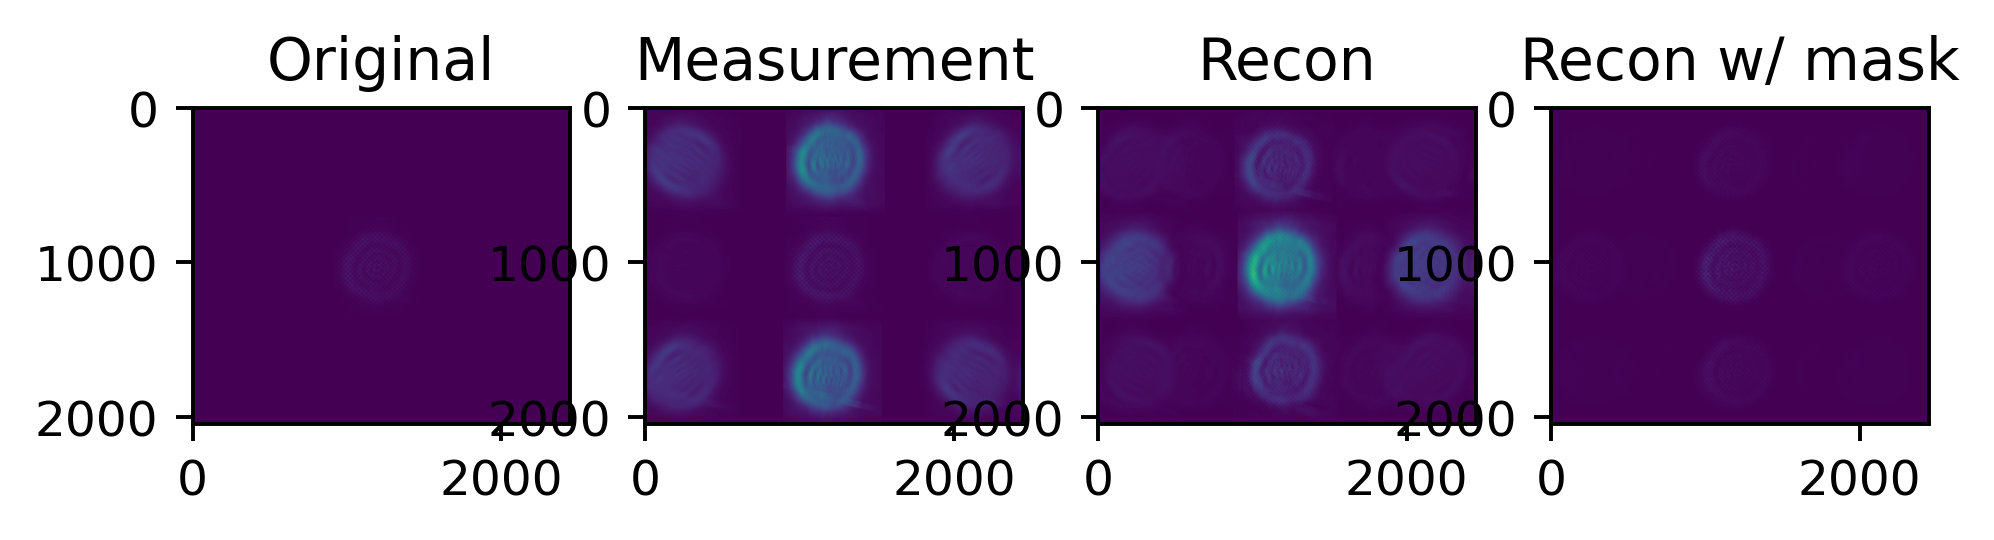

In [113]:
#simulate the measurement
shift_info = {'kernel':kernel}

measurement = torch.abs(method.calc_psi_z(torch.ones_like(cube),cube,shift_info))
recovered = torch.abs(method.calc_psiT_g(torch.ones_like(cube),measurement,shift_info))

recovered_wmask = torch.abs(method.calc_psiT_g(dispersed_mask,measurement,shift_info))


fig,ax = plt.subplots(1,4,dpi=350)
ax[0].imshow(cube[0,10,:]);ax[0].set_title('Original')
ax[1].imshow(measurement[0]); ax[1].set_title('Measurement')
ax[2].imshow(recovered[0,10,:]); ax[2].set_title('Recon')
ax[3].imshow(recovered_wmask[0,10,:]); ax[3].set_title('Recon w/ mask')


## Lets see how well the kernel fits the FTS data

In [114]:
from models.helper import FTSDataset
blamask = torch.zeros_like(cube)
sx,sy = cube.shape[2:]

blamask[...,sx//2-320:sx//2+320,sy//2-320:sy//2+320] = 1
undisp_cube = cube * blamask


dataset = FTSDataset(undispersed_cube=undisp_cube, spectra = spectras, crop=False)

x,y  = dataset[[0,1]]

Text(0.5, 1.0, 'pred meas')

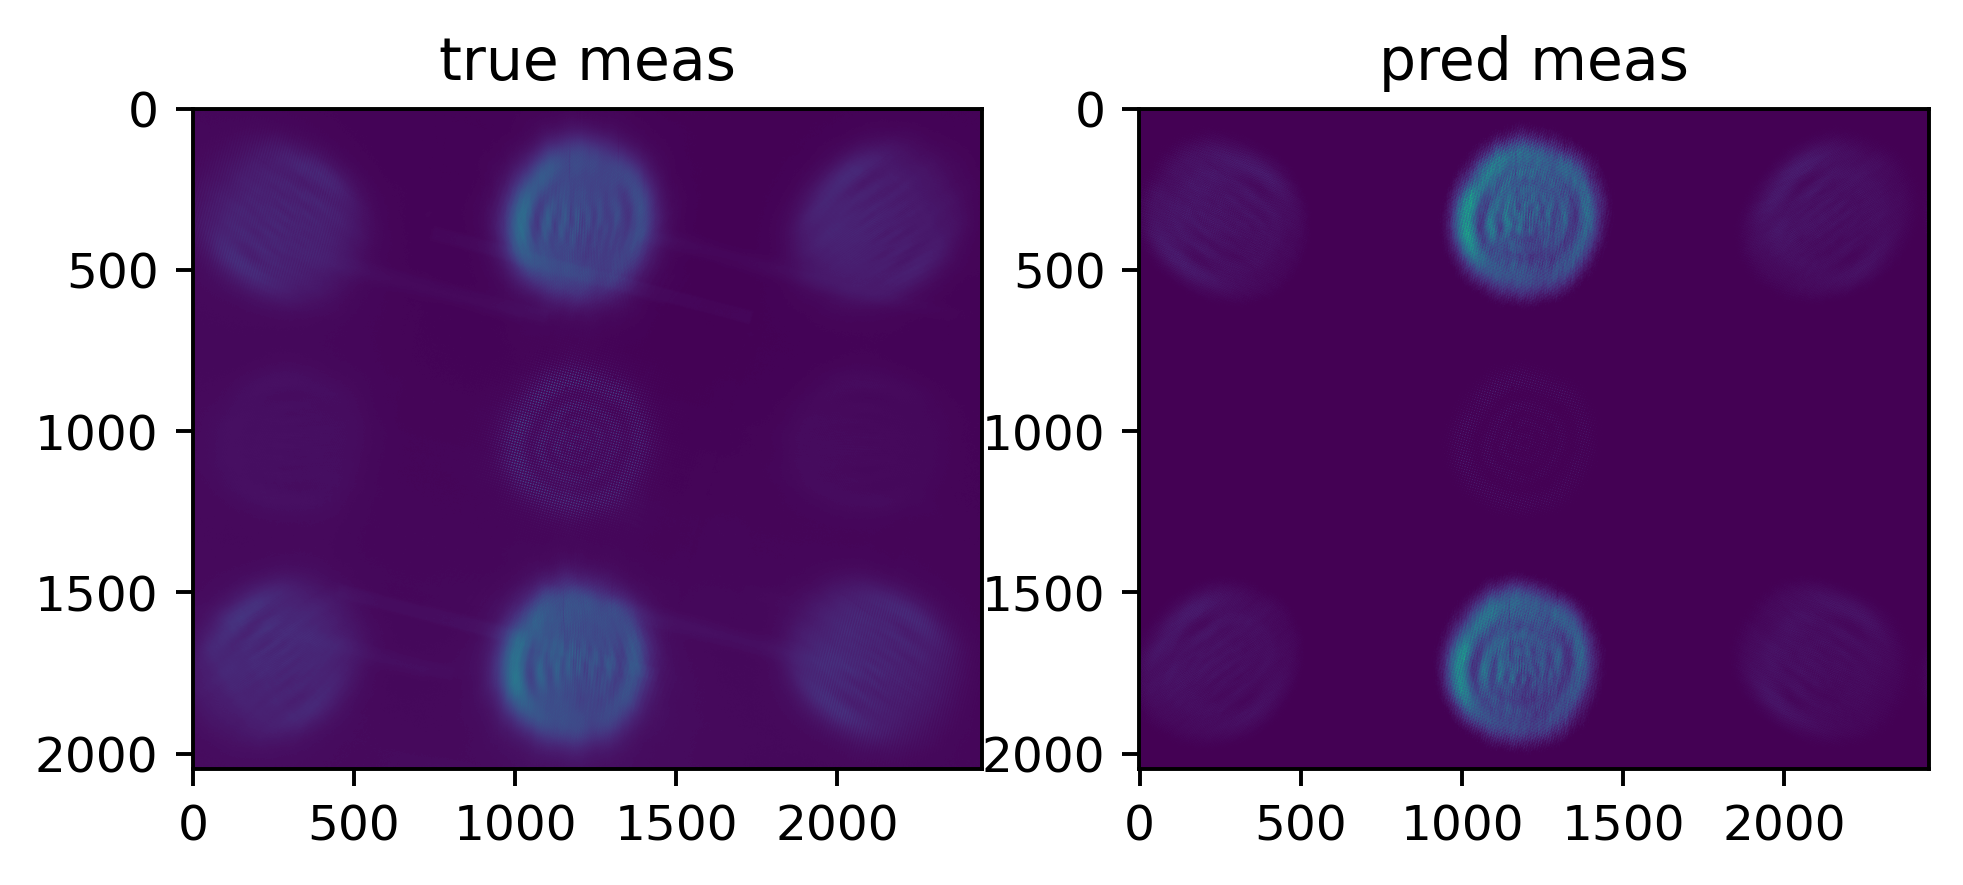

In [128]:
psudoy = y[:,15,:].unsqueeze(1).repeat(1,21,1,1)
meas = torch.abs(method.calc_psi_z(dispersed_mask,y,shift_info))
meas = torch.abs(method.calc_psi_z(dispersed_mask,psudoy,shift_info))


fig,ax = plt.subplots(1,2,dpi=350)

ax[0].imshow(x[0]); ax[0].set_title('true meas')
ax[1].imshow(meas[0]); ax[1].set_title('pred meas')


Text(0.5, 1.0, 'new recon')

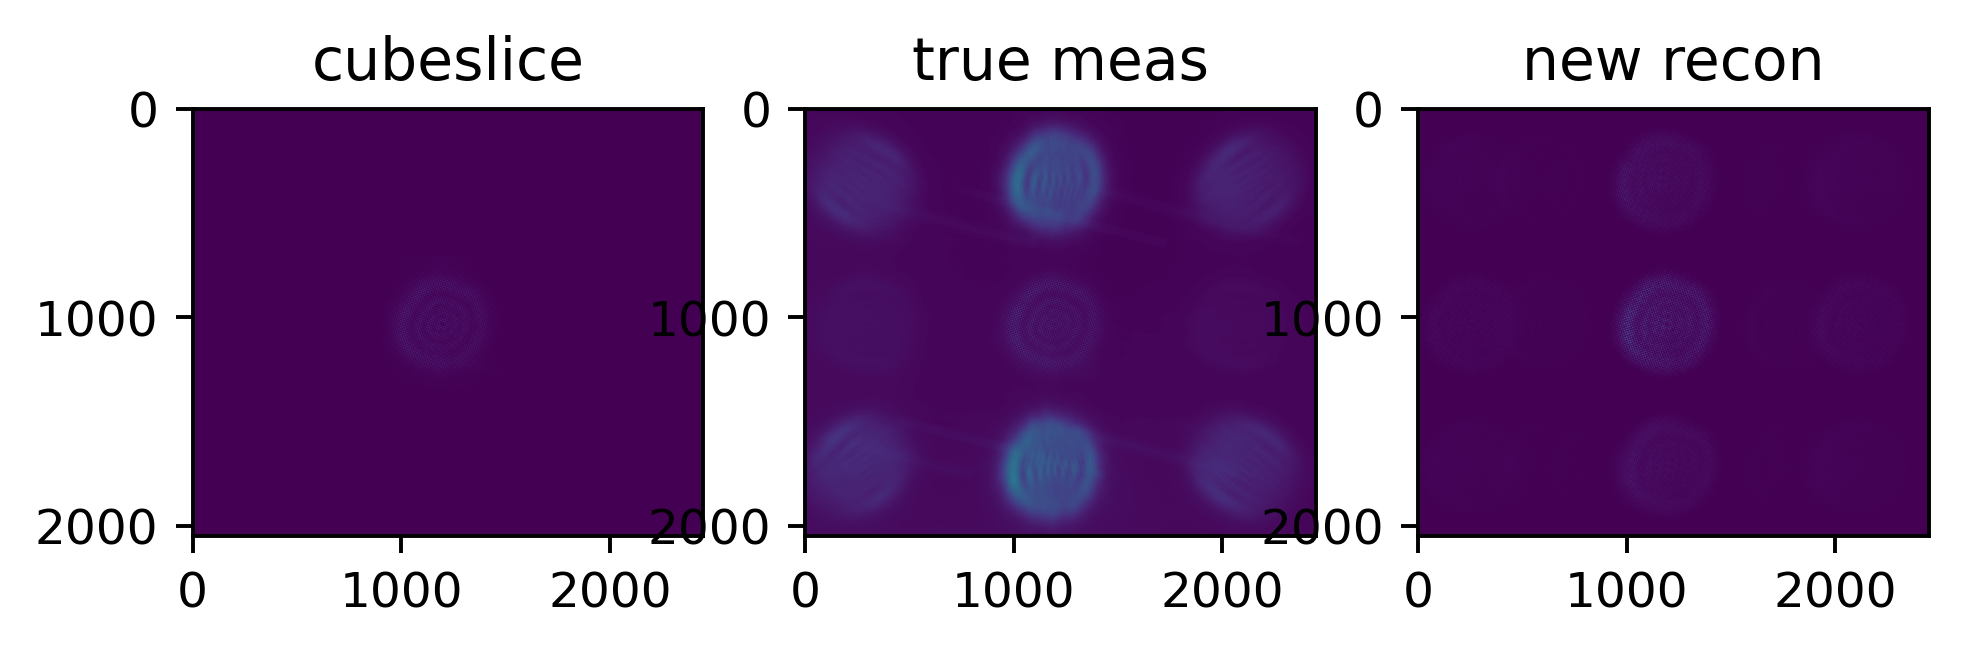

In [121]:
recovered = torch.abs(method.calc_psiT_g(dispersed_mask,x,shift_info))

fig,ax = plt.subplots(1,3,dpi=350)

ax[0].imshow(y[0,10,:]); ax[0].set_title('cubeslice')
ax[1].imshow(x[0]); ax[1].set_title('true meas')
ax[2].imshow(recovered[0,10,:]); ax[2].set_title('new recon')

## padding doesnt work :(

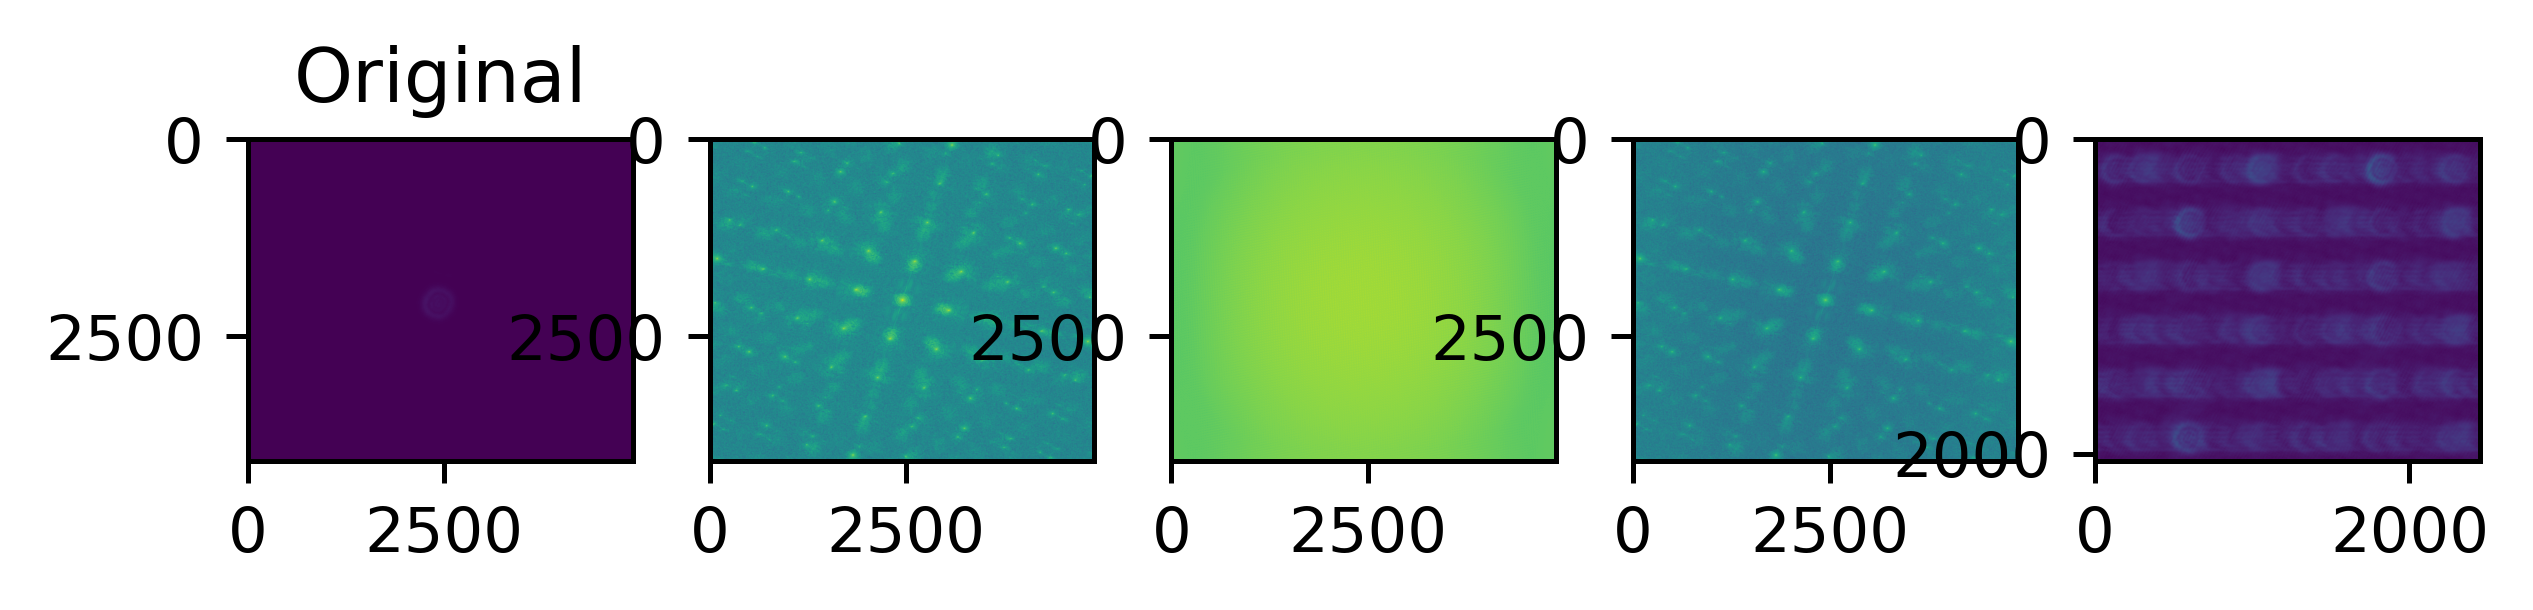

In [10]:
nx,ny = cube.shape[2:]
pad_x = int(np.ceil(nx/2))
pad_y = int(np.ceil(ny/2))
pad_cube = torch.nn.functional.pad(cube,(pad_y,pad_y,pad_x,pad_x))
pad_kernel = torch.nn.functional.pad(kernel9,(pad_y,pad_y,pad_x,pad_x))

# f_cube = torch.fft.fft2(pad_cube)
# f_kernel = torch.fft.fft2(pad_kernel)
# f_cube_undisp = f_cube / f_kernel
# cube_undisp = torch.fft.ifft2(f_cube_undisp)

f_cube = torch.fft.fft2(cube, s = (nx*2,ny*2))
f_kernel = torch.fft.fft2(kernel9, s = (nx*2,ny*2))
f_cube_undisp = f_cube / f_kernel
cube_undisp = torch.fft.ifft2(f_cube_undisp, s = (nx,ny))


fig,ax = plt.subplots(1,5,dpi=450)
ax[0].imshow(pad_cube[0,10,:]);ax[0].set_title('Original')
ax[1].imshow(np.log10(np.abs(torch.fft.fftshift(f_cube)))[0,10])
ax[2].imshow(np.log10(np.abs(torch.fft.fftshift(f_kernel)))[0,10])
ax[3].imshow(np.log10(np.abs(torch.fft.fftshift(f_cube_undisp)))[0,10])
ax[4].imshow(np.abs(cube_undisp)[0,10,:])

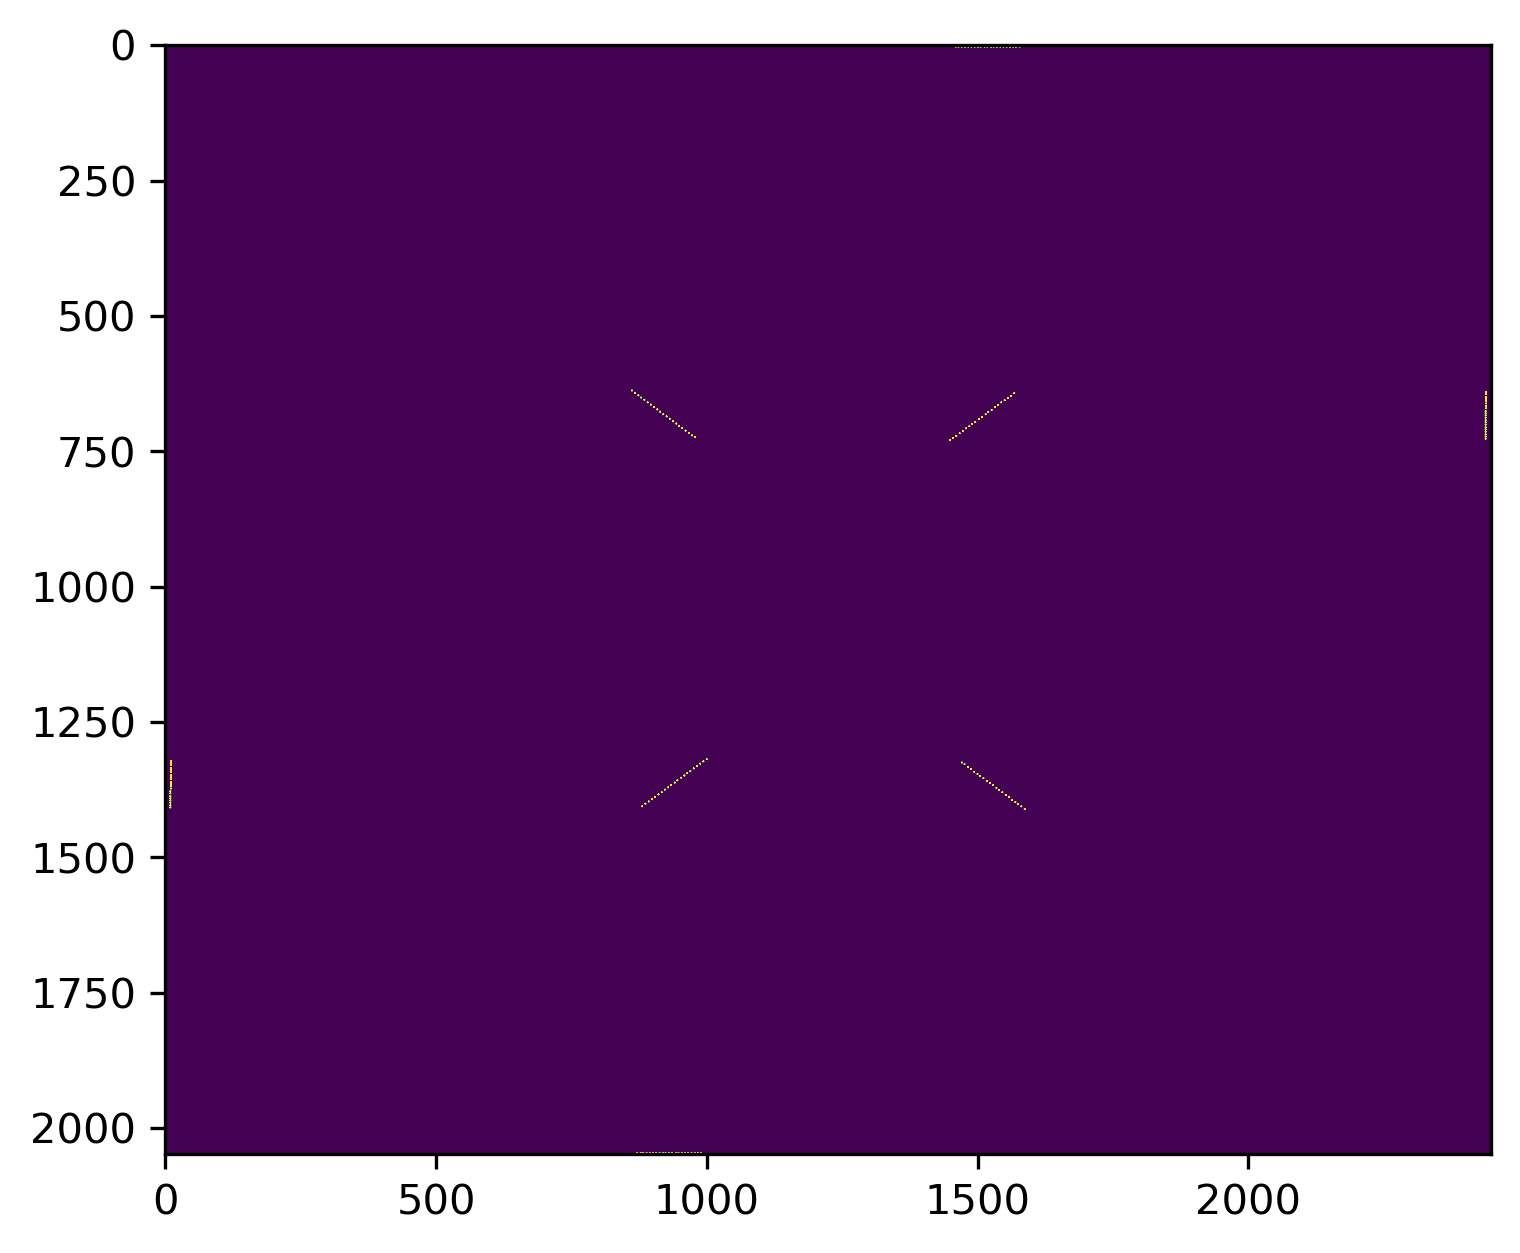

In [22]:
plt.figure(dpi=300)
plt.imshow(torch.sum(kernel,dim=1)[0]>0,vmax=0.1)